In [1]:
import pandas as pd
import numpy as np
import re

# NLP Imports
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split 
from tqdm import tqdm # Used to show a progress bar

In [2]:
upstream = []
lookback_days = None
random_seed = None

In [3]:
# Parameters
lookback_days = 10
product = {
    "nb": "/Users/mboussarov/_umsi/Capstone/umads_697_data_medics/pipeline/output/happy_path_exploration.ipynb"
}


## Read the train, dev and test data, do a very basic exploration

In [4]:
df_dev = pd.read_csv('../data/HumAID_data_v1.0/all_combined/all_dev.tsv', sep='\t')
df_train = pd.read_csv('../data/HumAID_data_v1.0/all_combined/all_train.tsv', sep='\t')
df_test = pd.read_csv('../data/HumAID_data_v1.0/all_combined/all_test.tsv', sep='\t')

df_all = pd.concat([df_dev, df_train, df_test])

df_dev.dropna(inplace=True)
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

df_all.dropna(inplace=True)

df_dev.head()

,tweet_id,tweet_text,class_label
0,1034712711223885825,RT @Forumkeralam1: #Google to contribute 1 mil...,rescue_volunteering_or_donation_effort
1,1031576019675705345,#KeralaFloods: How a WhatsApp group started by...,rescue_volunteering_or_donation_effort
2,1031253304288849920,#KeralaFloods Coz humanity matters. #KeralaSOS...,other_relevant_information
3,1032523376638808064,#KeralaFloods: @SrBachchan donates Rs 51 lakhs...,rescue_volunteering_or_donation_effort
4,1032287088190808064,#KeralaFloodRelief #KeralaFloods Guntur Divisi...,rescue_volunteering_or_donation_effort


In [5]:
# Show the number of rows in the dev set
print("Dev rows:", df_dev.shape[0])
print("Train rows:", df_train.shape[0])
print("Test rows:", df_test.shape[0])
print("All rows:", df_all.shape[0])
# Show the number of labels/categories
len(set(df_all['class_label']))

Dev rows: 7791
Train rows: 53516
Test rows: 15159
All rows: 76466


10

In [6]:
# Show the unique labels/categories
list(df_all['class_label'].unique())

['rescue_volunteering_or_donation_effort',
 'other_relevant_information',
 'requests_or_urgent_needs',
 'injured_or_dead_people',
 'infrastructure_and_utility_damage',
 'sympathy_and_support',
 'caution_and_advice',
 'not_humanitarian',
 'displaced_people_and_evacuations',
 'missing_or_found_people']

In [7]:
# Show the number of samples for each class - the data look like quite unbalanced,
#  validate in the train dataset, consider oversampling
# TODO: Consider classes with a minimum number of samples
Counter(df_all['class_label'])

Counter({'rescue_volunteering_or_donation_effort': 21274,
         'other_relevant_information': 12141,
         'requests_or_urgent_needs': 2618,
         'injured_or_dead_people': 7301,
         'infrastructure_and_utility_damage': 8162,
         'sympathy_and_support': 8924,
         'caution_and_advice': 5393,
         'not_humanitarian': 6296,
         'displaced_people_and_evacuations': 3999,
         'missing_or_found_people': 358})

In [8]:
# Do some token exploration
ws_tokens = Counter()
alpha_ws_tokens = Counter()
alpha_re_tokens = Counter()

for tweet in tqdm(df_all['tweet_text']):
    for t in tweet.split(): ws_tokens.update([t])
    if re.fullmatch(r'\w+', t):
        alpha_ws_tokens.update([t])
        
    alpha_re_tokens.update(re.findall(r'\b\w+\b', tweet))

  0%|                                                                                                                                                                  | 0/76466 [00:00<?, ?it/s]

  4%|█████▋                                                                                                                                              | 2927/76466 [00:00<00:02, 29266.26it/s]

  8%|███████████▉                                                                                                                                        | 6187/76466 [00:00<00:02, 31224.40it/s]

 12%|██████████████████                                                                                                                                  | 9310/76466 [00:00<00:02, 30257.54it/s]

 16%|███████████████████████▋                                                                                                                           | 12340/76466 [00:00<00:02, 28220.27it/s]

 20%|█████████████████████████████▏                                                                                                                     | 15181/76466 [00:00<00:02, 27621.87it/s]

 23%|██████████████████████████████████▌                                                                                                                | 17955/76466 [00:00<00:02, 27093.83it/s]

 27%|████████████████████████████████████████▎                                                                                                          | 20955/76466 [00:00<00:01, 27996.14it/s]

 33%|███████████████████████████████████████████████▉                                                                                                   | 24948/76466 [00:00<00:01, 31662.38it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                           | 28990/76466 [00:00<00:01, 34332.58it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                    | 32702/76466 [00:01<00:01, 35001.00it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                            | 36563/76466 [00:01<00:01, 36087.50it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                     | 40184/76466 [00:01<00:01, 33555.85it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                               | 43582/76466 [00:01<00:01, 30775.70it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 46724/76466 [00:01<00:01, 29283.76it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 50713/76466 [00:01<00:00, 32129.02it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 54268/76466 [00:01<00:00, 33075.25it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 57632/76466 [00:01<00:00, 31086.86it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60798/76466 [00:01<00:00, 29261.09it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 63776/76466 [00:02<00:00, 27544.84it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 67049/76466 [00:02<00:00, 28915.79it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 70521/76466 [00:02<00:00, 30502.10it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 73621/76466 [00:02<00:00, 30580.37it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76466/76466 [00:02<00:00, 30728.40it/s]

In [9]:
# Most of the tokens are not alphanumeric ones, must consider some additional tokenization
print(len(ws_tokens))
print(len(alpha_ws_tokens))
print(len(alpha_re_tokens))

154057
6318
98834


In [10]:
# Look at the most common, what do you see?
# Some stop words removal is needed
alpha_re_tokens.most_common(50)

[('the', 49289),
 ('to', 48869),
 ('in', 36166),
 ('of', 32877),
 ('and', 29723),
 ('for', 21817),
 ('a', 17547),
 ('is', 15529),
 ('Hurricane', 12988),
 ('are', 12733),
 ('RT', 11747),
 ('by', 11112),
 ('from', 9739),
 ('help', 9532),
 ('on', 9453),
 ('you', 8955),
 ('with', 8897),
 ('amp', 8409),
 ('people', 8125),
 ('as', 6913),
 ('have', 6913),
 ('at', 6790),
 ('The', 6724),
 ('that', 6512),
 ('this', 6325),
 ('I', 6004),
 ('be', 6000),
 ('all', 5914),
 ('Harvey', 5848),
 ('relief', 5797),
 ('California', 5617),
 ('has', 5550),
 ('earthquake', 5469),
 ('affected', 5381),
 ('Irma', 5376),
 ('will', 5258),
 ('our', 5131),
 ('damage', 4947),
 ('victims', 4895),
 ('Kerala', 4842),
 ('Dorian', 4582),
 ('can', 4516),
 ('it', 4507),
 ('those', 4176),
 ('flood', 4103),
 ('s', 4091),
 ('water', 4027),
 ('out', 3954),
 ('after', 3949),
 ('we', 3899)]

In [11]:
# No much difference for the simple tokens
ws_tokens.most_common(50)

[('the', 49176),
 ('to', 48627),
 ('in', 35855),
 ('of', 32816),
 ('and', 29528),
 ('for', 21648),
 ('a', 17195),
 ('is', 15380),
 ('are', 12653),
 ('Hurricane', 12425),
 ('RT', 11528),
 ('by', 11041),
 ('from', 9672),
 ('on', 9246),
 ('with', 8831),
 ('you', 7930),
 ('&amp;', 7853),
 ('help', 7770),
 ('people', 7263),
 ('as', 6882),
 ('have', 6875),
 ('at', 6680),
 ('The', 6615),
 ('that', 6275),
 ('be', 5935),
 ('this', 5873),
 ('has', 5536),
 ('all', 5511),
 ('I', 5264),
 ('will', 5227),
 ('our', 5118),
 ('affected', 4902),
 ('-', 4887),
 ('relief', 4843),
 ('those', 4162),
 ('California', 4106),
 ('damage', 4023),
 ('can', 3929),
 ('your', 3890),
 ('after', 3889),
 ('victims', 3694),
 ('we', 3693),
 ('it', 3557),
 ('out', 3542),
 ('their', 3477),
 ('#KeralaFloods', 3435),
 ('who', 3402),
 ('more', 3364),
 ('flood', 3290),
 ('We', 3204)]

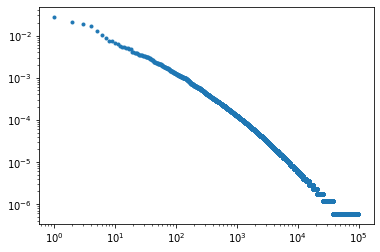

In [12]:
# Plot the word distribution - it follows the power law
x = [*range(len(alpha_re_tokens))]
total = sum([b for _, b in alpha_re_tokens.most_common()])
y = [b / total for _, b in alpha_re_tokens.most_common()]

ax = plt.plot(x, y, '.')
plt.yscale('log')
plt.xscale('log')

## Do a very basic vectorization and classification with logistic regression

In [13]:
%%time
# Next - add some classifiers
min_vocabulary = 200 # Changing this to higher value decreases the words in the vocabulary,
                     # consider finding the optimal value
                     # Also dropping this increases the F1 score

vectorizer = TfidfVectorizer(min_df=min_vocabulary, stop_words='english')
X_train = vectorizer.fit_transform(df_train['tweet_text'])
y_train = list(df_train['class_label'])
X_train.shape

CPU times: user 874 ms, sys: 20.3 ms, total: 894 ms
Wall time: 902 ms


(53516, 539)

In [14]:
# Note: the default vocabularly is pretty small, try to enhance it
len(vectorizer.vocabulary_)

539

In [15]:
# Prepate the logistic regression classifier
clf = LogisticRegression(solver='lbfgs', multi_class='auto', random_state=random_seed, max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [16]:
# Do a dummy classifier 1 and 2
dummy_clf1 = DummyClassifier(strategy="uniform", random_state=random_seed)
dummy_clf1.fit(X_train, y_train)

dummy_clf2 = DummyClassifier(strategy="most_frequent", random_state=random_seed)
dummy_clf2.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [17]:
# Predic on dev
X_dev = vectorizer.transform(df_dev['tweet_text'])
y_dev = list(df_dev['class_label'])

lr_tiny_dev_preds = clf.predict(X_dev)
rand_dev_preds = dummy_clf1.predict(X_dev)
mf_dev_preds = dummy_clf2.predict(X_dev)

In [18]:
# Score on dev - not bad of out-of-the-box, must improve
lr_f1 = f1_score(y_dev, lr_tiny_dev_preds, average='macro')
rand_f1 = f1_score(y_dev, rand_dev_preds, average='macro')
mf_f1 = f1_score(y_dev, mf_dev_preds, average='macro')

print(lr_f1)
print(rand_f1)
print(mf_f1)

0.6872610968967099
0.08939591199891664
0.04353850788231751


In [19]:
# Predic on test, must be about the same
X_test = vectorizer.transform(df_test['tweet_text'])
y_test = list(df_test['class_label'])

lr_tiny_test_preds = clf.predict(X_test)
rand_test_preds = dummy_clf1.predict(X_test)
mf_test_preds = dummy_clf2.predict(X_test)

In [20]:
# Score on test - about the same as dev
lr_f1 = f1_score(y_test, lr_tiny_test_preds, average='macro')
rand_f1 = f1_score(y_test, rand_test_preds, average='macro')
mf_f1 = f1_score(y_test, mf_test_preds, average='macro')

print(lr_f1)
print(rand_f1)
print(mf_f1)

0.6850973578671726
0.08224091658357752
0.04353615110698251


## Find out the f1 score for each class, find the best and worse

In [21]:
df_try = df_test

X_try = vectorizer.transform(df_try['tweet_text'])
y_try = list(df_try['class_label'])

preds = clf.predict(X_try)

for label in set(df_try['class_label']):
    print(label, f1_score(y_try, preds, labels=[label], average='macro'))

rescue_volunteering_or_donation_effort 0.8136200716845879
sympathy_and_support 0.76765855124737
requests_or_urgent_needs 0.4395348837209302


infrastructure_and_utility_damage 0.7795468462951622
injured_or_dead_people 0.8894181694453897
other_relevant_information 0.5378509196515004


displaced_people_and_evacuations 0.8589826142949131
caution_and_advice 0.6039654295882054
missing_or_found_people 0.6861313868613138


not_humanitarian 0.474264705882353


## Do bigrams see how this improves the F1 scores

In [22]:
bigram_vectorizer = TfidfVectorizer(stop_words='english', min_df=10, ngram_range=(1,2))
X_train = bigram_vectorizer.fit_transform(df_train['tweet_text'])
y_train = list(df_train['class_label'])
X_train.shape

(53516, 11323)

In [23]:
# Prepate the logistic regression classifier
clf = LogisticRegression(solver='lbfgs', multi_class='auto', random_state=random_seed, max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [24]:
# Predic on test, must be about the same
X_test = bigram_vectorizer.transform(df_test['tweet_text'])
y_test = list(df_test['class_label'])

lr_tiny_test_preds = clf.predict(X_test)

In [25]:
# Score on test - about the same as dev
lr_f1 = f1_score(y_test, lr_tiny_test_preds, average='macro')
print(lr_f1)

0.7109525239447484


In [26]:
# Find out the f1 score for each class, find the best and worse
df_try = df_test

X_try = bigram_vectorizer.transform(df_try['tweet_text'])
y_try = list(df_try['class_label'])

preds = clf.predict(X_try)

for label in set(df_try['class_label']):
    print(label, f1_score(y_try, preds, labels=[label], average='macro'))

rescue_volunteering_or_donation_effort 0.8360035603026258
sympathy_and_support 0.8002406738868832
requests_or_urgent_needs 0.4775086505190312


infrastructure_and_utility_damage 0.8004903463070794
injured_or_dead_people 0.902763561924258
other_relevant_information 0.5689655172413793


displaced_people_and_evacuations 0.8659254414650097
caution_and_advice 0.6443089430894309
missing_or_found_people 0.6829268292682927


not_humanitarian 0.530391715443494


## Predict the disaster types as labels

In [27]:
# Identify - what type of disasters and in what ratio
# Find the disaster locations - possibly some kind of topic modeling would be required. Find a location from text
#    https://medium.com/spatial-data-science/how-to-extract-locations-from-text-with-natural-language-processing-9b77035b3ea4

In [28]:
### Identify - what type of disasters are in a block of tweets
# Load the disaster files
# Earthquake
df_earthquake_dev = pd.read_csv('../data/HumAID_data_v1.0/event_type/earthquake_dev.tsv', sep='\t')
df_earthquake_train = pd.read_csv('../data/HumAID_data_v1.0/event_type/earthquake_train.tsv', sep='\t')
df_earthquake_test = pd.read_csv('../data/HumAID_data_v1.0/event_type/earthquake_test.tsv', sep='\t')

df_earthquake_dev['disaster_type'] = 'earthquake'
df_earthquake_train['disaster_type'] = 'earthquake'
df_earthquake_test['disaster_type'] = 'earthquake'

# Fire
df_fire_dev = pd.read_csv('../data/HumAID_data_v1.0/event_type/fire_dev.tsv', sep='\t')
df_fire_train = pd.read_csv('../data/HumAID_data_v1.0/event_type/fire_train.tsv', sep='\t')
df_fire_test = pd.read_csv('../data/HumAID_data_v1.0/event_type/fire_test.tsv', sep='\t')

df_fire_dev['disaster_type'] = 'fire'
df_fire_train['disaster_type'] = 'fire'
df_fire_test['disaster_type'] = 'fire'

# Flood
df_flood_dev = pd.read_csv('../data/HumAID_data_v1.0/event_type/flood_dev.tsv', sep='\t')
df_flood_train = pd.read_csv('../data/HumAID_data_v1.0/event_type/flood_train.tsv', sep='\t')
df_flood_test = pd.read_csv('../data/HumAID_data_v1.0/event_type/flood_test.tsv', sep='\t')

df_flood_dev['disaster_type'] = 'flood'
df_flood_train['disaster_type'] = 'flood'
df_flood_test['disaster_type'] = 'flood'

# Hurricane
df_hurricane_dev = pd.read_csv('../data/HumAID_data_v1.0/event_type/hurricane_dev.tsv', sep='\t')
df_hurricane_train = pd.read_csv('../data/HumAID_data_v1.0/event_type/hurricane_train.tsv', sep='\t')
df_hurricane_test = pd.read_csv('../data/HumAID_data_v1.0/event_type/hurricane_test.tsv', sep='\t')

df_hurricane_dev['disaster_type'] = 'hurricane'
df_hurricane_train['disaster_type'] = 'hurricane'
df_hurricane_test['disaster_type'] = 'hurricane'

df_disaster_dev = pd.concat([df_earthquake_dev, df_fire_dev, df_flood_dev, df_hurricane_dev])
df_disaster_train = pd.concat([df_earthquake_train, df_fire_train, df_flood_train, df_hurricane_train])
df_disaster_test = pd.concat([df_earthquake_test, df_fire_test, df_flood_test, df_hurricane_test])

In [29]:
df_disaster_train.sample(5)

,tweet_id,tweet_text,class_label,disaster_type
17864,908328157731680263,@thloveisradiant Im praying for you guys there...,sympathy_and_support,hurricane
37,730473637602574336,#Penniac residents to raise money for victims ...,rescue_volunteering_or_donation_effort,fire
14427,912408464479092737,RT @nccapconn: Hurricane Maria forecasts shift...,other_relevant_information,hurricane
5137,1064431837366312960,"Yes, What a name for a town all but destroyed...",infrastructure_and_utility_damage,fire
3700,1039532649860268033,"Ok my husband is way too crazy, as you know he...",not_humanitarian,hurricane


In [30]:
# Try predicting the disaster type of a corpus of tweets
bigram_vectorizer = TfidfVectorizer(stop_words='english', min_df=10, ngram_range=(1,2))
X_train = bigram_vectorizer.fit_transform(df_disaster_train['tweet_text'])
y_train = list(df_disaster_train['disaster_type'])
X_train.shape

(53522, 11324)

In [31]:
clf = LogisticRegression(solver='lbfgs', multi_class='auto', random_state=random_seed, max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [32]:
X_test = bigram_vectorizer.transform(df_disaster_test['tweet_text'])
y_test = list(df_disaster_test['disaster_type'])

lr_tiny_test_preds = clf.predict(X_test)

In [33]:
lr_f1 = f1_score(y_test, lr_tiny_test_preds, average='macro')
print(lr_f1)

0.9642183314925599


## Predict each disaster type individually, use the micro-score in the F1 score

In [34]:
Counter(lr_tiny_test_preds)

Counter({'earthquake': 1733, 'hurricane': 9261, 'flood': 2099, 'fire': 2067})

In [35]:
X_test = bigram_vectorizer.transform(df_earthquake_test['tweet_text'])
y_test = list(df_earthquake_test['disaster_type'])

lr_tiny_test_preds = clf.predict(X_test)
print(f1_score(y_test, lr_tiny_test_preds, average='micro'))
Counter(lr_tiny_test_preds)

0.9447264523406655


Counter({'earthquake': 1675, 'hurricane': 94, 'flood': 2, 'fire': 2})

In [36]:
X_test = bigram_vectorizer.transform(df_hurricane_test['tweet_text'])
y_test = list(df_hurricane_test['disaster_type'])

lr_tiny_test_preds = clf.predict(X_test)
print(f1_score(y_test, lr_tiny_test_preds, average='micro'))
Counter(lr_tiny_test_preds)

0.9913004684363149


Counter({'hurricane': 8888, 'fire': 15, 'flood': 7, 'earthquake': 56})

In [37]:
X_test = bigram_vectorizer.transform(df_flood_test['tweet_text'])
y_test = list(df_flood_test['disaster_type'])

lr_tiny_test_preds = clf.predict(X_test)
print(f1_score(y_test, lr_tiny_test_preds, average='micro'))
Counter(lr_tiny_test_preds)

0.9439927732610659


Counter({'flood': 2090, 'hurricane': 119, 'fire': 5})

In [38]:
X_test = bigram_vectorizer.transform(df_fire_test['tweet_text'])
y_test = list(df_fire_test['disaster_type'])

lr_tiny_test_preds = clf.predict(X_test)
print(f1_score(y_test, lr_tiny_test_preds, average='micro'))
Counter(lr_tiny_test_preds)

0.9265971907566832


Counter({'fire': 2045, 'hurricane': 160, 'earthquake': 2})

In [39]:
# TODO: Check if certain class of tweets is a better predictor of what kind of disaster is going on
class_labels = list(df_disaster_train['class_label'].unique())

for class_label in class_labels:
    df_tmp = df_disaster_train[df_disaster_train['class_label'] == class_label]

    bigram_vectorizer = TfidfVectorizer(stop_words='english', min_df=10, ngram_range=(1,2))
    X_train = bigram_vectorizer.fit_transform(df_tmp['tweet_text'])
    y_train = list(df_tmp['disaster_type'])
    #print(f'{class_label} train rows: ', X_train.shape[0])

    clf = LogisticRegression(solver='lbfgs', multi_class='auto', random_state=random_seed, max_iter=1000)
    clf.fit(X_train, y_train)

    X_test = bigram_vectorizer.transform(df_disaster_test['tweet_text'])
    y_test = list(df_disaster_test['disaster_type'])

    lr_tiny_test_preds = clf.predict(X_test)

    print(f'{class_label} F1 score: ', f1_score(y_test, lr_tiny_test_preds, average='macro'),
          ', train rows: ', X_train.shape[0])

other_relevant_information F1 score:  0.8983767645763492 , train rows:  8498


caution_and_advice F1 score:  0.8363553020362846 , train rows:  3773


sympathy_and_support F1 score:  0.9360284835263877 , train rows:  6248


infrastructure_and_utility_damage F1 score:  0.8679136543477588 , train rows:  5715


rescue_volunteering_or_donation_effort F1 score:  0.9456914321614958 , train rows:  14889


displaced_people_and_evacuations F1 score:  0.5897444464004213 , train rows:  2800


not_humanitarian F1 score:  0.8701403054527327 , train rows:  4407


requests_or_urgent_needs F1 score:  0.8179607341368798 , train rows:  1833


injured_or_dead_people F1 score:  0.9003534657397122 , train rows:  5109


missing_or_found_people F1 score:  0.20680291104231638 , train rows:  250


## Identify and plot the disaster locations from the tweets

In [40]:
# Locations!!!

In [41]:
import spacy
from spacy import displacy 

In [42]:
#!python -m spacy download en_core_web_sm
#!python -m spacy download xx_ent_wiki_sm

In [43]:
nlp = spacy.load('xx_ent_wiki_sm')

In [44]:
# Go through the dev data and collect all the locations
locations = []

for _, row in tqdm(df_disaster_dev.iterrows()):
    doc = nlp(row['tweet_text'])    
    locations.extend([[row['tweet_id'], ent.text, ent.start, ent.end] for ent in doc.ents if ent.label_ in ['LOC']])
    
df_locs = pd.DataFrame(locations, columns=['TweetID', 'Location', 'start', 'end'])

0it [00:00, ?it/s]

31it [00:00, 309.86it/s]

68it [00:00, 344.88it/s]

107it [00:00, 363.65it/s]

147it [00:00, 375.37it/s]

186it [00:00, 378.55it/s]

227it [00:00, 386.09it/s]

266it [00:00, 381.17it/s]

305it [00:00, 381.10it/s]

344it [00:00, 377.48it/s]

385it [00:01, 384.93it/s]

425it [00:01, 387.94it/s]

464it [00:01, 387.51it/s]

504it [00:01, 391.07it/s]

545it [00:01, 396.09it/s]

587it [00:01, 402.59it/s]

629it [00:01, 407.41it/s]

670it [00:01, 406.03it/s]

712it [00:01, 405.50it/s]

753it [00:01, 375.45it/s]

791it [00:02, 366.92it/s]

828it [00:02, 363.17it/s]

865it [00:02, 363.07it/s]

902it [00:02, 363.92it/s]

942it [00:02, 372.49it/s]

983it [00:02, 383.03it/s]

1024it [00:02, 389.34it/s]

1066it [00:02, 396.70it/s]

1109it [00:02, 406.07it/s]

1150it [00:02, 401.12it/s]

1191it [00:03, 390.96it/s]

1231it [00:03, 378.62it/s]

1269it [00:03, 368.63it/s]

1306it [00:03, 365.27it/s]

1343it [00:03, 360.69it/s]

1380it [00:03, 361.81it/s]

1418it [00:03, 366.34it/s]

1455it [00:03, 347.70it/s]

1490it [00:03, 345.54it/s]

1526it [00:04, 347.46it/s]

1563it [00:04, 352.74it/s]

1601it [00:04, 358.23it/s]

1639it [00:04, 362.58it/s]

1676it [00:04, 354.79it/s]

1712it [00:04, 349.97it/s]

1748it [00:04, 349.21it/s]

1784it [00:04, 352.32it/s]

1821it [00:04, 356.46it/s]

1857it [00:04, 351.68it/s]

1896it [00:05, 361.99it/s]

1935it [00:05, 369.60it/s]

1973it [00:05, 366.20it/s]

2010it [00:05, 364.95it/s]

2047it [00:05, 363.07it/s]

2084it [00:05, 348.20it/s]

2119it [00:05, 313.78it/s]

2152it [00:05, 312.97it/s]

2184it [00:05, 310.61it/s]

2218it [00:06, 315.98it/s]

2252it [00:06, 321.53it/s]

2288it [00:06, 329.02it/s]

2322it [00:06, 331.82it/s]

2356it [00:06, 326.53it/s]

2389it [00:06, 326.55it/s]

2423it [00:06, 329.36it/s]

2457it [00:06, 330.95it/s]

2492it [00:06, 334.60it/s]

2527it [00:06, 335.12it/s]

2561it [00:07, 334.64it/s]

2595it [00:07, 335.18it/s]

2629it [00:07, 333.64it/s]

2664it [00:07, 336.91it/s]

2698it [00:07, 337.50it/s]

2732it [00:07, 333.12it/s]

2766it [00:07, 326.05it/s]

2801it [00:07, 329.61it/s]

2835it [00:07, 330.83it/s]

2869it [00:08, 325.48it/s]

2902it [00:08, 324.93it/s]

2935it [00:08, 323.80it/s]

2968it [00:08, 323.35it/s]

3001it [00:08, 317.49it/s]

3033it [00:08, 317.05it/s]

3065it [00:08, 315.99it/s]

3100it [00:08, 325.61it/s]

3136it [00:08, 334.41it/s]

3173it [00:08, 342.48it/s]

3208it [00:09, 338.00it/s]

3242it [00:09, 329.51it/s]

3275it [00:09, 329.64it/s]

3308it [00:09, 322.69it/s]

3341it [00:09, 324.40it/s]

3374it [00:09, 316.52it/s]

3406it [00:09, 311.71it/s]

3440it [00:09, 318.07it/s]

3472it [00:09, 313.28it/s]

3504it [00:10, 314.93it/s]

3538it [00:10, 320.31it/s]

3571it [00:10, 319.98it/s]

3604it [00:10, 320.32it/s]

3637it [00:10, 323.11it/s]

3670it [00:10, 319.48it/s]

3702it [00:10, 318.37it/s]

3734it [00:10, 316.21it/s]

3766it [00:10, 313.72it/s]

3799it [00:10, 318.09it/s]

3833it [00:11, 320.57it/s]

3868it [00:11, 327.31it/s]

3905it [00:11, 337.83it/s]

3941it [00:11, 344.21it/s]

3978it [00:11, 350.18it/s]

4014it [00:11, 348.72it/s]

4051it [00:11, 354.18it/s]

4087it [00:11, 353.41it/s]

4123it [00:11, 352.32it/s]

4161it [00:11, 359.65it/s]

4197it [00:12, 352.54it/s]

4235it [00:12, 359.40it/s]

4271it [00:12, 350.18it/s]

4307it [00:12, 346.44it/s]

4343it [00:12, 349.88it/s]

4379it [00:12, 352.27it/s]

4415it [00:12, 352.62it/s]

4452it [00:12, 355.84it/s]

4488it [00:12, 352.22it/s]

4525it [00:12, 355.06it/s]

4561it [00:13, 353.32it/s]

4597it [00:13, 349.86it/s]

4632it [00:13, 348.89it/s]

4668it [00:13, 349.27it/s]

4705it [00:13, 354.50it/s]

4741it [00:13, 353.38it/s]

4777it [00:13, 350.09it/s]

4813it [00:13, 351.02it/s]

4849it [00:13, 349.25it/s]

4884it [00:14, 345.52it/s]

4919it [00:14, 341.14it/s]

4955it [00:14, 343.47it/s]

4990it [00:14, 344.13it/s]

5025it [00:14, 345.23it/s]

5061it [00:14, 349.49it/s]

5097it [00:14, 351.42it/s]

5133it [00:14, 350.23it/s]

5169it [00:14, 348.51it/s]

5204it [00:14, 346.51it/s]

5240it [00:15, 347.27it/s]

5276it [00:15, 349.49it/s]

5312it [00:15, 349.88it/s]

5347it [00:15, 345.19it/s]

5382it [00:15, 344.37it/s]

5417it [00:15, 345.34it/s]

5452it [00:15, 343.09it/s]

5487it [00:15, 341.10it/s]

5522it [00:15, 332.26it/s]

5557it [00:15, 336.05it/s]

5592it [00:16, 337.88it/s]

5627it [00:16, 339.70it/s]

5662it [00:16, 341.24it/s]

5697it [00:16, 338.89it/s]

5731it [00:16, 335.35it/s]

5766it [00:16, 336.97it/s]

5800it [00:16, 332.88it/s]

5834it [00:16, 329.62it/s]

5869it [00:16, 334.30it/s]

5904it [00:17, 338.38it/s]

5938it [00:17, 335.50it/s]

5972it [00:17, 322.91it/s]

6005it [00:17, 324.40it/s]

6038it [00:17, 326.01it/s]

6073it [00:17, 331.02it/s]

6107it [00:17, 331.52it/s]

6142it [00:17, 333.86it/s]

6177it [00:17, 338.16it/s]

6213it [00:17, 341.90it/s]

6248it [00:18, 338.96it/s]

6282it [00:18, 337.66it/s]

6316it [00:18, 335.55it/s]

6350it [00:18, 336.52it/s]

6385it [00:18, 337.92it/s]

6420it [00:18, 339.77it/s]

6454it [00:18, 332.40it/s]

6488it [00:18, 318.20it/s]

6520it [00:18, 311.14it/s]

6552it [00:18, 302.06it/s]

6583it [00:19, 297.48it/s]

6613it [00:19, 294.66it/s]

6644it [00:19, 295.87it/s]

6675it [00:19, 296.75it/s]

6705it [00:19, 291.12it/s]

6735it [00:19, 283.90it/s]

6764it [00:19, 283.44it/s]

6794it [00:19, 287.39it/s]

6823it [00:19, 288.09it/s]

6852it [00:20, 285.59it/s]

6881it [00:20, 284.63it/s]

6911it [00:20, 287.91it/s]

6942it [00:20, 293.64it/s]

6975it [00:20, 302.64it/s]

7006it [00:20, 294.43it/s]

7038it [00:20, 299.78it/s]

7069it [00:20, 296.93it/s]

7099it [00:20, 294.62it/s]

7129it [00:20, 293.11it/s]

7160it [00:21, 297.10it/s]

7190it [00:21, 297.00it/s]

7220it [00:21, 295.10it/s]

7251it [00:21, 298.42it/s]

7281it [00:21, 298.65it/s]

7311it [00:21, 295.92it/s]

7342it [00:21, 297.81it/s]

7372it [00:21, 297.09it/s]

7402it [00:21, 297.78it/s]

7432it [00:21, 294.33it/s]

7462it [00:22, 295.60it/s]

7492it [00:22, 292.10it/s]

7522it [00:22, 287.31it/s]

7552it [00:22, 289.63it/s]

7583it [00:22, 294.33it/s]

7613it [00:22, 288.47it/s]

7645it [00:22, 297.18it/s]

7679it [00:22, 307.68it/s]

7712it [00:22, 311.54it/s]

7745it [00:23, 315.13it/s]

7779it [00:23, 321.36it/s]

7793it [00:23, 336.31it/s]

In [45]:
df_locs.sample(50)

,TweetID,Location,start,end
5430,1167526319263027201,Coast Guard,11,13
1095,1062067140629393409,California,14,15
4321,909306005405696000,Cuba,6,7
3005,1039467618355347458,York,30,31
612,1176499540960206848,Pakistan,16,17
5835,1168393420412477440,Florence,20,21
586,1176521103235330048,New Delhi,16,18
4576,905438295370285057,Houston,14,15
1319,1062211539082584064,State History,16,18
694,728587665226928128,Wildfire-Struck Alberta,4,8


In [46]:
locations = Counter(df_locs['Location']).most_common(20)

df_locs_most_common = pd.DataFrame(locations, columns=['location', 'count'])

df_locs_most_common

,location,count
0,California,373
1,Kerala,283
2,Puerto Rico,236
3,Florida,217
4,Haiti,130
5,Mexico,118
6,Nebraska,112
7,Texas,107
8,Mozambique,100
9,Hurricane Florence,97


In [47]:
import geopandas as gpd 
import geopy

from geopy.extra.rate_limiter import RateLimiter

In [48]:
locator = geopy.geocoders.Nominatim(user_agent='mygeocoder')
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

df_locs_most_common['address'] = df_locs_most_common['location'].apply(geocode)

In [49]:
df_locs_most_common

,location,count,address
0,California,373,"(California, United States, (36.7014631, -118...."
1,Kerala,283,"(Kerala, India, (10.3528744, 76.5120396))"
2,Puerto Rico,236,"(Puerto Rico, United States, (18.19897685, -66..."
3,Florida,217,"(Florida, United States, (27.7567667, -81.4639..."
4,Haiti,130,"(Ayiti, (19.1399952, -72.3570972))"
5,Mexico,118,"(México, (23.6585116, -102.0077097))"
6,Nebraska,112,"(Nebraska, United States, (41.7370229, -99.587..."
7,Texas,107,"(Texas, United States, (31.2638905, -98.5456116))"
8,Mozambique,100,"(Moçambique, (-19.302233, 34.9144977))"
9,Hurricane Florence,97,"(Hurricane Creek, Florence, Gadsden County, Fl..."


In [50]:
df_locs_most_common['coordinates'] = df_locs_most_common['address'].apply(
    lambda loc: tuple(loc.point) if loc else None
)
df_locs_most_common[['latitude', 'longitude', 'altitude']] = pd.DataFrame(
    df_locs_most_common['coordinates'].tolist(), index=df_locs_most_common.index
)

In [51]:
df_locs_most_common

,location,count,address,coordinates,latitude,longitude,altitude
0,California,373,"(California, United States, (36.7014631, -118....","(36.7014631, -118.755997, 0.0)",36.701463,-118.755997,0.0
1,Kerala,283,"(Kerala, India, (10.3528744, 76.5120396))","(10.3528744, 76.5120396, 0.0)",10.352874,76.512040,0.0
2,Puerto Rico,236,"(Puerto Rico, United States, (18.19897685, -66...","(18.19897685, -66.26152219418967, 0.0)",18.198977,-66.261522,0.0
3,Florida,217,"(Florida, United States, (27.7567667, -81.4639...","(27.7567667, -81.4639835, 0.0)",27.756767,-81.463983,0.0
4,Haiti,130,"(Ayiti, (19.1399952, -72.3570972))","(19.1399952, -72.3570972, 0.0)",19.139995,-72.357097,0.0
5,Mexico,118,"(México, (23.6585116, -102.0077097))","(23.6585116, -102.0077097, 0.0)",23.658512,-102.007710,0.0
6,Nebraska,112,"(Nebraska, United States, (41.7370229, -99.587...","(41.7370229, -99.5873816, 0.0)",41.737023,-99.587382,0.0
7,Texas,107,"(Texas, United States, (31.2638905, -98.5456116))","(31.2638905, -98.5456116, 0.0)",31.263890,-98.545612,0.0
8,Mozambique,100,"(Moçambique, (-19.302233, 34.9144977))","(-19.302233, 34.9144977, 0.0)",-19.302233,34.914498,0.0
9,Hurricane Florence,97,"(Hurricane Creek, Florence, Gadsden County, Fl...","(30.5896683, -84.4759528, 0.0)",30.589668,-84.475953,0.0


In [52]:
import folium
from folium.plugins import FastMarkerCluster

folium_map = folium.Map(location=[59.338315,18.089960],
    zoom_start=2,
    tiles='CartoDB dark_matter')

FastMarkerCluster(data=list(zip(df_locs_most_common['latitude'].values,
                                df_locs_most_common['longitude'].values))).add_to(folium_map)
folium.LayerControl().add_to(folium_map)
folium_map

## Use dense vectors and word embedding to test the predictions

In [53]:
### Word2vec exploration - check https://radimrehurek.com/gensim/models/word2vec.html
from nltk.corpus import stopwords

In [54]:
vectorizer = TfidfVectorizer(min_df=50, stop_words='english')
vectorizer.fit(df_disaster_train['tweet_text'])

TfidfVectorizer(min_df=50, stop_words='english')

In [55]:
analyzer = vectorizer.build_analyzer()

In [56]:
tokens = [analyzer(s) for s in list(df_disaster_train['tweet_text'])]
tokens[:2]

[['feel',
  'little',
  'uneasy',
  'idea',
  'work',
  'tomorrow',
  'aftershocks',
  'strong',
  'eqnz',
  'wellingtonearthquake'],
 ['eqnz',
  'interislander',
  'ferry',
  'docking',
  'aborted',
  'huge',
  'magnitude',
  'quake',
  'sailings',
  'hold']]

In [57]:
%%time
from gensim.models.word2vec import Word2Vec

quick_model = Word2Vec(sentences=tokens, vector_size=100, window=2,
                       min_count=10, workers=4, seed=random_seed)

CPU times: user 4.28 s, sys: 45.6 ms, total: 4.32 s
Wall time: 1.51 s


In [58]:
quick_model.wv.get_vector('quake')

array([ 0.61761737, -0.8274039 ,  0.18905592, -0.00195632, -0.01675954,
        0.31766087,  0.05806428, -0.6869638 ,  0.70284194, -0.1447702 ,
       -0.35068706,  0.3886651 ,  0.26211038, -0.2848492 , -0.2872237 ,
        0.07138237,  0.80843526,  0.1319111 , -0.8640108 ,  0.07524198,
        0.0715074 ,  0.35984087,  0.15407723,  0.11089543, -0.6460062 ,
       -0.1434243 , -0.19910611, -0.63120615, -0.73337567,  0.17375386,
       -0.06324625, -0.32255363, -0.36123276,  0.10803369,  0.11531721,
        0.18282966, -0.6624519 ,  0.3516574 , -0.12843557,  0.08090799,
       -0.17139123,  1.1050642 ,  0.8850008 , -0.43790144,  0.25344238,
       -0.7555698 ,  0.46842393, -0.44281143, -0.32216418,  0.24151142,
       -0.24644016,  0.3646483 , -0.13028802,  0.30162293,  0.17597501,
       -0.07897681,  0.86925834, -0.30822125, -0.23917435, -1.029434  ,
        0.37637794,  0.4165277 , -0.8558768 ,  0.00880709,  0.70359635,
       -0.14710002,  0.55025643, -0.07355865,  0.77373546,  0.29

In [59]:
quick_model.wv.similar_by_word("quake")[:10]

[('matthew', 0.8530034422874451),
 ('earthquake', 0.8327711820602417),
 ('cyclone', 0.832724392414093),
 ('magnitude', 0.8294973969459534),
 ('earthquakes', 0.825534462928772),
 ('idai', 0.8200674653053284),
 ('irmas', 0.8195391297340393),
 ('deadly', 0.8167228102684021),
 ('powerful', 0.816655695438385),
 ('harveys', 0.8053423166275024)]

In [60]:
# Build vectors for sentences, use for training a model
def generate_dense_features(tokenized_texts, model):
    result = []
    for tokens in tqdm(tokenized_texts):
        filtered_tokens = [t for t in tokens if t in model.wv.index_to_key] 
        if len(filtered_tokens) > 0:
            vec = np.mean(model.wv[filtered_tokens], axis=0) 
        else:
            vec = np.zeros(model.wv.vector_size)
        result.append(vec)
    return np.array(result)

X_train = generate_dense_features(tokens, quick_model)

  0%|                                                                                                                                                                  | 0/53522 [00:00<?, ?it/s]

  0%|▋                                                                                                                                                     | 241/53522 [00:00<00:22, 2405.29it/s]

  1%|█▍                                                                                                                                                    | 497/53522 [00:00<00:21, 2493.62it/s]

  1%|██                                                                                                                                                    | 747/53522 [00:00<00:21, 2433.65it/s]

  2%|██▊                                                                                                                                                  | 1008/53522 [00:00<00:21, 2498.86it/s]

  2%|███▌                                                                                                                                                 | 1262/53522 [00:00<00:20, 2508.75it/s]

  3%|████▏                                                                                                                                                | 1514/53522 [00:00<00:21, 2474.90it/s]

  3%|████▉                                                                                                                                                | 1770/53522 [00:00<00:20, 2497.94it/s]

  4%|█████▌                                                                                                                                               | 2020/53522 [00:00<00:21, 2437.04it/s]

  4%|██████▎                                                                                                                                              | 2278/53522 [00:00<00:20, 2477.41it/s]

  5%|███████                                                                                                                                              | 2529/53522 [00:01<00:20, 2484.47it/s]

  5%|███████▋                                                                                                                                             | 2778/53522 [00:01<00:20, 2443.70it/s]

  6%|████████▍                                                                                                                                            | 3037/53522 [00:01<00:20, 2484.86it/s]

  6%|█████████▏                                                                                                                                           | 3315/53522 [00:01<00:19, 2572.26it/s]

  7%|██████████                                                                                                                                           | 3595/53522 [00:01<00:18, 2636.29it/s]

  7%|██████████▋                                                                                                                                          | 3859/53522 [00:01<00:18, 2619.52it/s]

  8%|███████████▍                                                                                                                                         | 4122/53522 [00:01<00:18, 2619.14it/s]

  8%|████████████▏                                                                                                                                        | 4393/53522 [00:01<00:18, 2642.88it/s]

  9%|████████████▉                                                                                                                                        | 4658/53522 [00:01<00:18, 2621.51it/s]

  9%|█████████████▋                                                                                                                                       | 4921/53522 [00:01<00:19, 2474.31it/s]

 10%|██████████████▍                                                                                                                                      | 5171/53522 [00:02<00:22, 2179.79it/s]

 10%|███████████████                                                                                                                                      | 5396/53522 [00:02<00:24, 1997.84it/s]

 10%|███████████████▌                                                                                                                                     | 5603/53522 [00:02<00:25, 1893.89it/s]

 11%|████████████████▏                                                                                                                                    | 5797/53522 [00:02<00:25, 1859.28it/s]

 11%|████████████████▋                                                                                                                                    | 5986/53522 [00:02<00:26, 1772.65it/s]

 12%|█████████████████▏                                                                                                                                   | 6166/53522 [00:02<00:27, 1735.78it/s]

 12%|█████████████████▊                                                                                                                                   | 6376/53522 [00:02<00:25, 1832.54it/s]

 12%|██████████████████▍                                                                                                                                  | 6622/53522 [00:02<00:23, 2005.10it/s]

 13%|███████████████████                                                                                                                                  | 6848/53522 [00:03<00:22, 2076.99it/s]

 13%|███████████████████▋                                                                                                                                 | 7071/53522 [00:03<00:21, 2120.41it/s]

 14%|████████████████████▍                                                                                                                                | 7335/53522 [00:03<00:20, 2270.09it/s]

 14%|█████████████████████                                                                                                                                | 7564/53522 [00:03<00:20, 2272.89it/s]

 15%|█████████████████████▋                                                                                                                               | 7795/53522 [00:03<00:20, 2282.31it/s]

 15%|██████████████████████▎                                                                                                                              | 8025/53522 [00:03<00:20, 2201.60it/s]

 15%|██████████████████████▉                                                                                                                              | 8247/53522 [00:03<00:22, 2008.30it/s]

 16%|███████████████████████▌                                                                                                                             | 8452/53522 [00:03<00:22, 1982.43it/s]

 16%|████████████████████████                                                                                                                             | 8653/53522 [00:03<00:23, 1940.78it/s]

 17%|████████████████████████▋                                                                                                                            | 8849/53522 [00:03<00:23, 1879.28it/s]

 17%|█████████████████████████▏                                                                                                                           | 9039/53522 [00:04<00:24, 1811.44it/s]

 17%|█████████████████████████▋                                                                                                                           | 9222/53522 [00:04<00:24, 1803.80it/s]

 18%|██████████████████████████▏                                                                                                                          | 9404/53522 [00:04<00:26, 1695.59it/s]

 18%|██████████████████████████▋                                                                                                                          | 9588/53522 [00:04<00:25, 1734.60it/s]

 18%|███████████████████████████▏                                                                                                                         | 9763/53522 [00:04<00:25, 1729.33it/s]

 19%|███████████████████████████▋                                                                                                                         | 9943/53522 [00:04<00:25, 1742.79it/s]

 19%|███████████████████████████▉                                                                                                                        | 10119/53522 [00:04<00:24, 1744.89it/s]

 19%|████████████████████████████▍                                                                                                                       | 10294/53522 [00:04<00:25, 1713.32it/s]

 20%|████████████████████████████▉                                                                                                                       | 10484/53522 [00:04<00:24, 1767.05it/s]

 20%|█████████████████████████████▍                                                                                                                      | 10662/53522 [00:05<00:24, 1758.04it/s]

 20%|██████████████████████████████                                                                                                                      | 10865/53522 [00:05<00:23, 1835.67it/s]

 21%|██████████████████████████████▌                                                                                                                     | 11049/53522 [00:05<00:23, 1828.75it/s]

 21%|███████████████████████████████                                                                                                                     | 11242/53522 [00:05<00:22, 1857.13it/s]

 21%|███████████████████████████████▌                                                                                                                    | 11428/53522 [00:05<00:23, 1783.24it/s]

 22%|████████████████████████████████                                                                                                                    | 11608/53522 [00:05<00:23, 1775.45it/s]

 22%|████████████████████████████████▌                                                                                                                   | 11787/53522 [00:05<00:23, 1743.41it/s]

 22%|█████████████████████████████████                                                                                                                   | 11962/53522 [00:05<00:23, 1732.81it/s]

 23%|█████████████████████████████████▌                                                                                                                  | 12140/53522 [00:05<00:23, 1746.19it/s]

 23%|██████████████████████████████████                                                                                                                  | 12323/53522 [00:05<00:23, 1764.53it/s]

 23%|██████████████████████████████████▌                                                                                                                 | 12500/53522 [00:06<00:23, 1732.35it/s]

 24%|███████████████████████████████████                                                                                                                 | 12693/53522 [00:06<00:22, 1789.50it/s]

 24%|███████████████████████████████████▌                                                                                                                | 12873/53522 [00:06<00:23, 1758.65it/s]

 24%|████████████████████████████████████                                                                                                                | 13055/53522 [00:06<00:22, 1772.60it/s]

 25%|████████████████████████████████████▌                                                                                                               | 13233/53522 [00:06<00:22, 1766.17it/s]

 25%|█████████████████████████████████████                                                                                                               | 13413/53522 [00:06<00:22, 1775.03it/s]

 25%|█████████████████████████████████████▌                                                                                                              | 13591/53522 [00:06<00:23, 1725.64it/s]

 26%|██████████████████████████████████████                                                                                                              | 13765/53522 [00:06<00:23, 1728.01it/s]

 26%|██████████████████████████████████████▌                                                                                                             | 13960/53522 [00:06<00:22, 1788.64it/s]

 26%|███████████████████████████████████████                                                                                                             | 14140/53522 [00:07<00:23, 1704.10it/s]

 27%|███████████████████████████████████████▌                                                                                                            | 14312/53522 [00:07<00:27, 1451.21it/s]

 27%|███████████████████████████████████████▉                                                                                                            | 14464/53522 [00:07<00:27, 1415.34it/s]

 27%|████████████████████████████████████████▍                                                                                                           | 14611/53522 [00:07<00:28, 1362.32it/s]

 28%|████████████████████████████████████████▊                                                                                                           | 14751/53522 [00:07<00:28, 1347.04it/s]

 28%|█████████████████████████████████████████▏                                                                                                          | 14888/53522 [00:07<00:28, 1344.15it/s]

 28%|█████████████████████████████████████████▌                                                                                                          | 15024/53522 [00:07<00:28, 1341.71it/s]

 28%|█████████████████████████████████████████▉                                                                                                          | 15160/53522 [00:07<00:28, 1336.68it/s]

 29%|██████████████████████████████████████████▎                                                                                                         | 15295/53522 [00:07<00:29, 1279.15it/s]

 29%|██████████████████████████████████████████▋                                                                                                         | 15424/53522 [00:08<00:30, 1265.71it/s]

 29%|███████████████████████████████████████████                                                                                                         | 15552/53522 [00:08<00:29, 1267.76it/s]

 29%|███████████████████████████████████████████▎                                                                                                        | 15684/53522 [00:08<00:29, 1282.12it/s]

 30%|███████████████████████████████████████████▋                                                                                                        | 15817/53522 [00:08<00:29, 1294.59it/s]

 30%|████████████████████████████████████████████                                                                                                        | 15947/53522 [00:08<00:29, 1294.65it/s]

 30%|████████████████████████████████████████████▍                                                                                                       | 16077/53522 [00:08<00:29, 1254.11it/s]

 30%|████████████████████████████████████████████▊                                                                                                       | 16203/53522 [00:08<00:29, 1244.69it/s]

 31%|█████████████████████████████████████████████▏                                                                                                      | 16329/53522 [00:08<00:29, 1248.88it/s]

 31%|█████████████████████████████████████████████▌                                                                                                      | 16455/53522 [00:08<00:29, 1252.06it/s]

 31%|█████████████████████████████████████████████▊                                                                                                      | 16587/53522 [00:08<00:29, 1269.93it/s]

 31%|██████████████████████████████████████████████▏                                                                                                     | 16715/53522 [00:09<00:29, 1256.34it/s]

 31%|██████████████████████████████████████████████▌                                                                                                     | 16841/53522 [00:09<00:30, 1206.69it/s]

 32%|██████████████████████████████████████████████▉                                                                                                     | 16963/53522 [00:09<00:30, 1179.74it/s]

 32%|███████████████████████████████████████████████▎                                                                                                    | 17093/53522 [00:09<00:30, 1210.65it/s]

 32%|███████████████████████████████████████████████▌                                                                                                    | 17222/53522 [00:09<00:29, 1231.29it/s]

 32%|███████████████████████████████████████████████▉                                                                                                    | 17350/53522 [00:09<00:29, 1243.66it/s]

 33%|████████████████████████████████████████████████▎                                                                                                   | 17475/53522 [00:09<00:29, 1234.31it/s]

 33%|████████████████████████████████████████████████▋                                                                                                   | 17599/53522 [00:09<00:29, 1230.25it/s]

 33%|█████████████████████████████████████████████████                                                                                                   | 17724/53522 [00:09<00:28, 1235.69it/s]

 33%|█████████████████████████████████████████████████▍                                                                                                  | 17864/53522 [00:09<00:27, 1279.80it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                  | 17993/53522 [00:10<00:28, 1243.55it/s]

 34%|██████████████████████████████████████████████████                                                                                                  | 18118/53522 [00:10<00:28, 1233.79it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                 | 18243/53522 [00:10<00:28, 1237.73it/s]

 34%|██████████████████████████████████████████████████▊                                                                                                 | 18376/53522 [00:10<00:27, 1263.41it/s]

 35%|███████████████████████████████████████████████████▏                                                                                                | 18507/53522 [00:10<00:27, 1273.36it/s]

 35%|███████████████████████████████████████████████████▌                                                                                                | 18635/53522 [00:10<00:28, 1228.26it/s]

 35%|███████████████████████████████████████████████████▊                                                                                                | 18759/53522 [00:10<00:28, 1231.42it/s]

 35%|████████████████████████████████████████████████████▏                                                                                               | 18888/53522 [00:10<00:27, 1247.36it/s]

 36%|████████████████████████████████████████████████████▌                                                                                               | 19013/53522 [00:10<00:27, 1235.74it/s]

 36%|████████████████████████████████████████████████████▉                                                                                               | 19143/53522 [00:11<00:27, 1249.29it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                              | 19269/53522 [00:11<00:28, 1209.95it/s]

 36%|█████████████████████████████████████████████████████▌                                                                                              | 19391/53522 [00:11<00:29, 1151.03it/s]

 36%|█████████████████████████████████████████████████████▉                                                                                              | 19507/53522 [00:11<00:29, 1142.46it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                             | 19623/53522 [00:11<00:29, 1146.21it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                             | 19741/53522 [00:11<00:29, 1154.02it/s]

 37%|██████████████████████████████████████████████████████▉                                                                                             | 19872/53522 [00:11<00:28, 1194.88it/s]

 37%|███████████████████████████████████████████████████████▎                                                                                            | 19995/53522 [00:11<00:27, 1203.30it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                            | 20116/53522 [00:11<00:27, 1204.96it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                            | 20241/53522 [00:11<00:27, 1217.16it/s]

 38%|████████████████████████████████████████████████████████▎                                                                                           | 20363/53522 [00:12<00:28, 1164.03it/s]

 38%|████████████████████████████████████████████████████████▋                                                                                           | 20502/53522 [00:12<00:26, 1226.96it/s]

 39%|█████████████████████████████████████████████████████████                                                                                           | 20633/53522 [00:12<00:26, 1248.47it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                          | 20759/53522 [00:12<00:26, 1234.18it/s]

 39%|█████████████████████████████████████████████████████████▊                                                                                          | 20887/53522 [00:12<00:26, 1245.60it/s]

 39%|██████████████████████████████████████████████████████████                                                                                          | 21012/53522 [00:12<00:27, 1178.94it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                         | 21146/53522 [00:12<00:26, 1223.96it/s]

 40%|██████████████████████████████████████████████████████████▉                                                                                         | 21309/53522 [00:12<00:24, 1340.01it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                        | 21472/53522 [00:12<00:22, 1424.13it/s]

 40%|███████████████████████████████████████████████████████████▊                                                                                        | 21625/53522 [00:13<00:21, 1454.34it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                       | 21781/53522 [00:13<00:21, 1482.44it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                       | 21941/53522 [00:13<00:20, 1511.96it/s]

 41%|█████████████████████████████████████████████████████████████                                                                                       | 22093/53522 [00:13<00:21, 1471.39it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                      | 22241/53522 [00:13<00:22, 1419.29it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                      | 22384/53522 [00:13<00:22, 1365.19it/s]

 42%|██████████████████████████████████████████████████████████████▎                                                                                     | 22522/53522 [00:13<00:22, 1351.63it/s]

 42%|██████████████████████████████████████████████████████████████▋                                                                                     | 22658/53522 [00:13<00:22, 1349.73it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                     | 22794/53522 [00:13<00:23, 1304.32it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                    | 22933/53522 [00:13<00:23, 1327.74it/s]

 43%|███████████████████████████████████████████████████████████████▊                                                                                    | 23067/53522 [00:14<00:23, 1302.05it/s]

 43%|████████████████████████████████████████████████████████████████▏                                                                                   | 23204/53522 [00:14<00:22, 1320.60it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                   | 23337/53522 [00:14<00:22, 1319.72it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                   | 23470/53522 [00:14<00:22, 1307.77it/s]

 44%|█████████████████████████████████████████████████████████████████▎                                                                                  | 23601/53522 [00:14<00:23, 1291.22it/s]

 44%|█████████████████████████████████████████████████████████████████▌                                                                                  | 23731/53522 [00:14<00:23, 1253.02it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                  | 23873/53522 [00:14<00:22, 1300.02it/s]

 45%|██████████████████████████████████████████████████████████████████▍                                                                                 | 24020/53522 [00:14<00:21, 1347.40it/s]

 45%|██████████████████████████████████████████████████████████████████▊                                                                                 | 24156/53522 [00:14<00:21, 1336.55it/s]

 45%|███████████████████████████████████████████████████████████████████▏                                                                                | 24295/53522 [00:15<00:21, 1349.04it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                                | 24435/53522 [00:15<00:21, 1361.62it/s]

 46%|███████████████████████████████████████████████████████████████████▉                                                                                | 24572/53522 [00:15<00:22, 1301.99it/s]

 46%|████████████████████████████████████████████████████████████████████▎                                                                               | 24703/53522 [00:15<00:22, 1259.44it/s]

 46%|████████████████████████████████████████████████████████████████████▋                                                                               | 24839/53522 [00:15<00:22, 1283.87it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                               | 24975/53522 [00:15<00:21, 1304.53it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                              | 25106/53522 [00:15<00:22, 1271.19it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                              | 25234/53522 [00:15<00:22, 1237.43it/s]

 47%|██████████████████████████████████████████████████████████████████████▏                                                                             | 25371/53522 [00:15<00:22, 1274.68it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                             | 25503/53522 [00:15<00:21, 1282.84it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                             | 25632/53522 [00:16<00:22, 1245.73it/s]

 48%|███████████████████████████████████████████████████████████████████████▏                                                                            | 25757/53522 [00:16<00:22, 1245.80it/s]

 48%|███████████████████████████████████████████████████████████████████████▌                                                                            | 25892/53522 [00:16<00:21, 1273.60it/s]

 49%|███████████████████████████████████████████████████████████████████████▉                                                                            | 26023/53522 [00:16<00:21, 1281.42it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                           | 26152/53522 [00:16<00:21, 1283.68it/s]

 49%|████████████████████████████████████████████████████████████████████████▋                                                                           | 26306/53522 [00:16<00:20, 1357.73it/s]

 50%|█████████████████████████████████████████████████████████████████████████▎                                                                          | 26521/53522 [00:16<00:16, 1592.91it/s]

 50%|█████████████████████████████████████████████████████████████████████████▉                                                                          | 26747/53522 [00:16<00:14, 1789.67it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                         | 26962/53522 [00:16<00:14, 1891.71it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                        | 27186/53522 [00:16<00:13, 1990.52it/s]

 51%|███████████████████████████████████████████████████████████████████████████▊                                                                        | 27394/53522 [00:17<00:12, 2017.15it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                       | 27631/53522 [00:17<00:12, 2117.78it/s]

 52%|█████████████████████████████████████████████████████████████████████████████                                                                       | 27846/53522 [00:17<00:12, 2127.18it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▌                                                                      | 28071/53522 [00:17<00:11, 2159.21it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▎                                                                     | 28308/53522 [00:17<00:11, 2220.95it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▉                                                                     | 28531/53522 [00:17<00:11, 2174.11it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▌                                                                    | 28762/53522 [00:17<00:11, 2212.99it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▏                                                                   | 28988/53522 [00:17<00:11, 2226.57it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                   | 29211/53522 [00:17<00:11, 2172.58it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▍                                                                  | 29429/53522 [00:17<00:11, 2116.47it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████                                                                  | 29667/53522 [00:18<00:10, 2188.88it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▋                                                                 | 29887/53522 [00:18<00:10, 2177.37it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▎                                                                | 30107/53522 [00:18<00:10, 2183.51it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                                | 30326/53522 [00:18<00:10, 2154.18it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▍                                                               | 30550/53522 [00:18<00:10, 2178.89it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                               | 30777/53522 [00:18<00:10, 2205.37it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▋                                                              | 31005/53522 [00:18<00:10, 2224.03it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▎                                                             | 31228/53522 [00:18<00:10, 2200.34it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▉                                                             | 31449/53522 [00:18<00:10, 2195.24it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▋                                                            | 31689/53522 [00:19<00:09, 2254.60it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 31915/53522 [00:19<00:09, 2243.24it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 32151/53522 [00:19<00:09, 2277.24it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 32379/53522 [00:19<00:09, 2274.94it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 32607/53522 [00:19<00:09, 2219.66it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 32831/53522 [00:19<00:09, 2224.81it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 33064/53522 [00:19<00:09, 2250.34it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████                                                        | 33290/53522 [00:19<00:09, 2230.49it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 33514/53522 [00:19<00:09, 2195.12it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 33738/53522 [00:19<00:08, 2206.74it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 33964/53522 [00:20<00:08, 2221.26it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 34187/53522 [00:20<00:08, 2221.31it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 34415/53522 [00:20<00:08, 2235.35it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 34639/53522 [00:20<00:08, 2212.97it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 34868/53522 [00:20<00:08, 2234.62it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 35092/53522 [00:20<00:08, 2208.51it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 35316/53522 [00:20<00:08, 2213.36it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 35538/53522 [00:20<00:08, 2176.32it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 35756/53522 [00:20<00:08, 2174.87it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 35974/53522 [00:20<00:08, 2160.43it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 36191/53522 [00:21<00:08, 2123.16it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 36412/53522 [00:21<00:07, 2147.94it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 36627/53522 [00:21<00:07, 2142.51it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 36852/53522 [00:21<00:07, 2173.56it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 37070/53522 [00:21<00:07, 2175.28it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 37303/53522 [00:21<00:07, 2220.66it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 37526/53522 [00:21<00:07, 2155.76it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 37743/53522 [00:21<00:07, 2156.04it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 37959/53522 [00:21<00:07, 2143.09it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 38176/53522 [00:21<00:07, 2147.83it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 38394/53522 [00:22<00:07, 2157.17it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 38610/53522 [00:22<00:06, 2145.21it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 38825/53522 [00:22<00:06, 2125.95it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 39038/53522 [00:22<00:06, 2106.44it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 39249/53522 [00:22<00:06, 2057.13it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 39455/53522 [00:22<00:06, 2033.08it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 39659/53522 [00:22<00:06, 2025.02it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 39862/53522 [00:22<00:06, 1962.41it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 40083/53522 [00:22<00:06, 2029.82it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 40287/53522 [00:23<00:06, 1984.47it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 40494/53522 [00:23<00:06, 2007.70it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 40704/53522 [00:23<00:06, 2032.92it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 40908/53522 [00:23<00:06, 1999.97it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 41112/53522 [00:23<00:06, 2009.12it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 41320/53522 [00:23<00:06, 2028.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 41524/53522 [00:23<00:05, 2025.28it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 41727/53522 [00:23<00:05, 2024.49it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 41930/53522 [00:23<00:05, 1995.61it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 42135/53522 [00:23<00:05, 2010.73it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 42337/53522 [00:24<00:05, 1943.72it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 42540/53522 [00:24<00:05, 1967.50it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 42756/53522 [00:24<00:05, 2022.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 42962/53522 [00:24<00:05, 2032.63it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 43186/53522 [00:24<00:04, 2093.77it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 43396/53522 [00:24<00:04, 2078.11it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 43605/53522 [00:24<00:04, 2065.40it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 43812/53522 [00:24<00:04, 2005.14it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 44016/53522 [00:24<00:04, 2014.56it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 44229/53522 [00:24<00:04, 2047.93it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 44435/53522 [00:25<00:05, 1736.94it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 44617/53522 [00:25<00:05, 1574.80it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 44783/53522 [00:25<00:05, 1471.05it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 44936/53522 [00:25<00:06, 1416.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 45082/53522 [00:25<00:06, 1325.34it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 45218/53522 [00:25<00:06, 1302.26it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 45350/53522 [00:25<00:06, 1290.70it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 45481/53522 [00:25<00:06, 1267.62it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 45609/53522 [00:26<00:06, 1242.72it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 45734/53522 [00:26<00:06, 1210.52it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 45856/53522 [00:26<00:06, 1204.47it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 45977/53522 [00:26<00:06, 1198.69it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 46112/53522 [00:26<00:05, 1240.69it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 46237/53522 [00:26<00:05, 1239.48it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 46362/53522 [00:26<00:05, 1225.98it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 46497/53522 [00:26<00:05, 1260.60it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 46630/53522 [00:26<00:05, 1279.27it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 46773/53522 [00:27<00:05, 1322.17it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 46906/53522 [00:27<00:05, 1291.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 47036/53522 [00:27<00:05, 1272.02it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 47184/53522 [00:27<00:04, 1331.96it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 47338/53522 [00:27<00:04, 1392.14it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 47478/53522 [00:27<00:04, 1393.94it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 47652/53522 [00:27<00:03, 1494.72it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 47812/53522 [00:27<00:03, 1525.90it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 47970/53522 [00:27<00:03, 1541.48it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 48137/53522 [00:27<00:03, 1575.94it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 48295/53522 [00:28<00:03, 1559.59it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 48452/53522 [00:28<00:03, 1528.10it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 48606/53522 [00:28<00:03, 1531.31it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 48773/53522 [00:28<00:03, 1567.74it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 48932/53522 [00:28<00:02, 1573.73it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 49090/53522 [00:28<00:02, 1571.99it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 49249/53522 [00:28<00:02, 1571.70it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 49407/53522 [00:28<00:02, 1548.34it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 49562/53522 [00:28<00:02, 1519.09it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 49717/53522 [00:28<00:02, 1527.41it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 49872/53522 [00:29<00:02, 1532.99it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 50039/53522 [00:29<00:02, 1566.48it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 50196/53522 [00:29<00:02, 1461.00it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 50355/53522 [00:29<00:02, 1497.11it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 50508/53522 [00:29<00:02, 1506.00it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 50660/53522 [00:29<00:01, 1487.98it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 50821/53522 [00:29<00:01, 1522.12it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 50981/53522 [00:29<00:01, 1542.30it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 51146/53522 [00:29<00:01, 1571.68it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 51305/53522 [00:29<00:01, 1576.95it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 51483/53522 [00:30<00:01, 1637.10it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 51647/53522 [00:30<00:01, 1623.79it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 51821/53522 [00:30<00:01, 1654.43it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 52000/53522 [00:30<00:00, 1691.52it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 52170/53522 [00:30<00:00, 1658.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 52339/53522 [00:30<00:00, 1666.99it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 52609/53522 [00:30<00:00, 1970.66it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 52883/53522 [00:30<00:00, 2198.46it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 53175/53522 [00:30<00:00, 2409.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 53447/53522 [00:30<00:00, 2501.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53522/53522 [00:31<00:00, 1725.52it/s]

In [61]:
y_train = list(df_disaster_train['class_label'])

In [62]:
# Prepate the logistic regression classifier
clf = LogisticRegression(solver='lbfgs', multi_class='auto', random_state=random_seed, max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [63]:
# Validate
tokens_test = [analyzer(s) for s in list(df_disaster_test['tweet_text'])]
tokens_test[:2]

[['earthquake',
  'new',
  'zealand',
  'massive',
  'billions',
  'dollars',
  'damage',
  'followed',
  'storm'],
 ['pictures', 'alarming', 'extent', 'quake', 'damage', 'building', 'clear']]

In [64]:
X_test = generate_dense_features(tokens_test, quick_model)
y_test = list(df_disaster_test['class_label'])

lr_tiny_test_preds = clf.predict(X_test)

f1_score(y_test, lr_tiny_test_preds, average='macro')

  0%|                                                                                                                                                                  | 0/15160 [00:00<?, ?it/s]

  1%|█▍                                                                                                                                                    | 150/15160 [00:00<00:10, 1496.04it/s]

  2%|███                                                                                                                                                   | 311/15160 [00:00<00:09, 1559.87it/s]

  3%|████▋                                                                                                                                                 | 472/15160 [00:00<00:09, 1581.14it/s]

  4%|██████▏                                                                                                                                               | 631/15160 [00:00<00:09, 1510.16it/s]

  5%|███████▊                                                                                                                                              | 789/15160 [00:00<00:09, 1532.67it/s]

  6%|█████████▎                                                                                                                                            | 943/15160 [00:00<00:09, 1513.64it/s]

  7%|██████████▉                                                                                                                                          | 1113/15160 [00:00<00:08, 1569.13it/s]

  8%|████████████▍                                                                                                                                        | 1271/15160 [00:00<00:08, 1565.26it/s]

  9%|██████████████                                                                                                                                       | 1428/15160 [00:00<00:09, 1488.81it/s]

 10%|███████████████▌                                                                                                                                     | 1578/15160 [00:01<00:10, 1323.06it/s]

 11%|████████████████▊                                                                                                                                    | 1714/15160 [00:01<00:11, 1212.15it/s]

 12%|██████████████████                                                                                                                                   | 1839/15160 [00:01<00:11, 1159.90it/s]

 13%|███████████████████▍                                                                                                                                 | 1984/15160 [00:01<00:10, 1234.88it/s]

 14%|████████████████████▊                                                                                                                                | 2118/15160 [00:01<00:10, 1262.43it/s]

 15%|██████████████████████                                                                                                                               | 2247/15160 [00:01<00:10, 1248.27it/s]

 16%|███████████████████████▎                                                                                                                             | 2374/15160 [00:01<00:10, 1178.91it/s]

 16%|████████████████████████▌                                                                                                                            | 2494/15160 [00:01<00:10, 1173.47it/s]

 17%|█████████████████████████▋                                                                                                                           | 2613/15160 [00:01<00:11, 1139.89it/s]

 18%|██████████████████████████▊                                                                                                                          | 2728/15160 [00:02<00:11, 1101.53it/s]

 19%|███████████████████████████▉                                                                                                                         | 2839/15160 [00:02<00:11, 1077.93it/s]

 19%|████████████████████████████▉                                                                                                                        | 2948/15160 [00:02<00:11, 1042.20it/s]

 20%|██████████████████████████████                                                                                                                       | 3054/15160 [00:02<00:11, 1045.85it/s]

 21%|███████████████████████████████                                                                                                                      | 3161/15160 [00:02<00:11, 1049.65it/s]

 22%|████████████████████████████████▏                                                                                                                    | 3279/15160 [00:02<00:10, 1085.51it/s]

 22%|█████████████████████████████████▎                                                                                                                   | 3388/15160 [00:02<00:11, 1062.44it/s]

 23%|██████████████████████████████████▍                                                                                                                  | 3501/15160 [00:02<00:10, 1079.43it/s]

 24%|███████████████████████████████████▍                                                                                                                 | 3610/15160 [00:02<00:10, 1056.40it/s]

 25%|████████████████████████████████████▋                                                                                                                | 3730/15160 [00:03<00:10, 1096.67it/s]

 25%|█████████████████████████████████████▊                                                                                                               | 3843/15160 [00:03<00:10, 1099.95it/s]

 26%|██████████████████████████████████████▊                                                                                                              | 3954/15160 [00:03<00:10, 1071.39it/s]

 27%|████████████████████████████████████████▏                                                                                                             | 4062/15160 [00:03<00:11, 984.38it/s]

 27%|█████████████████████████████████████████▏                                                                                                            | 4162/15160 [00:03<00:11, 944.18it/s]

 28%|██████████████████████████████████████████▏                                                                                                           | 4258/15160 [00:03<00:12, 867.22it/s]

 29%|███████████████████████████████████████████                                                                                                           | 4347/15160 [00:03<00:12, 848.21it/s]

 29%|███████████████████████████████████████████▊                                                                                                          | 4433/15160 [00:03<00:12, 825.83it/s]

 30%|████████████████████████████████████████████▋                                                                                                         | 4517/15160 [00:03<00:12, 825.10it/s]

 30%|█████████████████████████████████████████████▌                                                                                                        | 4600/15160 [00:04<00:12, 820.25it/s]

 31%|██████████████████████████████████████████████▎                                                                                                       | 4683/15160 [00:04<00:13, 783.56it/s]

 31%|███████████████████████████████████████████████                                                                                                       | 4762/15160 [00:04<00:13, 784.27it/s]

 32%|███████████████████████████████████████████████▉                                                                                                      | 4841/15160 [00:04<00:13, 783.21it/s]

 32%|████████████████████████████████████████████████▋                                                                                                     | 4920/15160 [00:04<00:13, 764.25it/s]

 33%|█████████████████████████████████████████████████▍                                                                                                    | 4997/15160 [00:04<00:13, 755.67it/s]

 33%|██████████████████████████████████████████████████▏                                                                                                   | 5078/15160 [00:04<00:13, 769.92it/s]

 34%|███████████████████████████████████████████████████                                                                                                   | 5156/15160 [00:04<00:13, 765.54it/s]

 35%|███████████████████████████████████████████████████▉                                                                                                  | 5245/15160 [00:04<00:12, 799.76it/s]

 35%|████████████████████████████████████████████████████▋                                                                                                 | 5326/15160 [00:05<00:12, 790.88it/s]

 36%|█████████████████████████████████████████████████████▌                                                                                                | 5408/15160 [00:05<00:12, 795.46it/s]

 36%|██████████████████████████████████████████████████████▎                                                                                               | 5488/15160 [00:05<00:12, 794.67it/s]

 37%|███████████████████████████████████████████████████████▏                                                                                              | 5572/15160 [00:05<00:11, 806.75it/s]

 37%|███████████████████████████████████████████████████████▉                                                                                              | 5653/15160 [00:05<00:11, 804.04it/s]

 38%|████████████████████████████████████████████████████████▋                                                                                             | 5734/15160 [00:05<00:12, 784.48it/s]

 38%|█████████████████████████████████████████████████████████▌                                                                                            | 5818/15160 [00:05<00:11, 799.42it/s]

 39%|██████████████████████████████████████████████████████████▍                                                                                           | 5903/15160 [00:05<00:11, 811.63it/s]

 40%|███████████████████████████████████████████████████████████▌                                                                                          | 6016/15160 [00:05<00:10, 899.45it/s]

 40%|████████████████████████████████████████████████████████████▋                                                                                         | 6133/15160 [00:05<00:09, 979.11it/s]

 41%|█████████████████████████████████████████████████████████████▋                                                                                        | 6238/15160 [00:06<00:08, 998.90it/s]

 42%|██████████████████████████████████████████████████████████████▋                                                                                       | 6339/15160 [00:06<00:09, 972.27it/s]

 42%|███████████████████████████████████████████████████████████████▋                                                                                      | 6437/15160 [00:06<00:09, 929.36it/s]

 43%|████████████████████████████████████████████████████████████████▌                                                                                     | 6531/15160 [00:06<00:09, 901.85it/s]

 44%|█████████████████████████████████████████████████████████████████▌                                                                                    | 6625/15160 [00:06<00:09, 911.14it/s]

 44%|██████████████████████████████████████████████████████████████████▍                                                                                   | 6717/15160 [00:06<00:09, 895.74it/s]

 45%|███████████████████████████████████████████████████████████████████▍                                                                                  | 6819/15160 [00:06<00:08, 929.72it/s]

 46%|████████████████████████████████████████████████████████████████████▍                                                                                 | 6913/15160 [00:06<00:08, 920.69it/s]

 46%|█████████████████████████████████████████████████████████████████████▍                                                                                | 7013/15160 [00:06<00:08, 941.65it/s]

 47%|██████████████████████████████████████████████████████████████████████▎                                                                               | 7108/15160 [00:06<00:08, 907.13it/s]

 48%|███████████████████████████████████████████████████████████████████████▎                                                                              | 7206/15160 [00:07<00:08, 925.31it/s]

 48%|████████████████████████████████████████████████████████████████████████▎                                                                             | 7306/15160 [00:07<00:08, 946.12it/s]

 49%|█████████████████████████████████████████████████████████████████████████▏                                                                            | 7401/15160 [00:07<00:08, 886.71it/s]

 50%|██████████████████████████████████████████████████████████████████████████▏                                                                          | 7546/15160 [00:07<00:07, 1044.56it/s]

 51%|███████████████████████████████████████████████████████████████████████████▌                                                                         | 7687/15160 [00:07<00:06, 1147.60it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                       | 7849/15160 [00:07<00:05, 1284.24it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▉                                                                      | 8027/15160 [00:07<00:04, 1428.28it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▌                                                                    | 8194/15160 [00:07<00:04, 1498.27it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████                                                                   | 8348/15160 [00:07<00:04, 1508.68it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▋                                                                 | 8509/15160 [00:08<00:04, 1538.64it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▏                                                               | 8673/15160 [00:08<00:04, 1566.50it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                              | 8841/15160 [00:08<00:03, 1599.48it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 9002/15160 [00:08<00:03, 1576.92it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                           | 9160/15160 [00:08<00:03, 1572.73it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 9318/15160 [00:08<00:03, 1573.86it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 9476/15160 [00:08<00:03, 1552.13it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 9643/15160 [00:08<00:03, 1586.14it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 9807/15160 [00:08<00:03, 1601.85it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 9968/15160 [00:08<00:03, 1602.38it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 10137/15160 [00:09<00:03, 1627.06it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 10309/15160 [00:09<00:02, 1653.28it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 10475/15160 [00:09<00:02, 1644.39it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 10640/15160 [00:09<00:02, 1634.50it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 10804/15160 [00:09<00:02, 1595.35it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 10964/15160 [00:09<00:02, 1565.10it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 11121/15160 [00:09<00:02, 1542.44it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 11276/15160 [00:09<00:02, 1534.65it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 11430/15160 [00:09<00:02, 1533.31it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 11584/15160 [00:09<00:02, 1506.82it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 11747/15160 [00:10<00:02, 1542.30it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 11911/15160 [00:10<00:02, 1570.42it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 12069/15160 [00:10<00:02, 1526.66it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 12239/15160 [00:10<00:01, 1574.25it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 12404/15160 [00:10<00:01, 1593.63it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 12564/15160 [00:10<00:01, 1503.72it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 12716/15160 [00:10<00:01, 1246.10it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 12849/15160 [00:10<00:02, 1149.67it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 12970/15160 [00:11<00:02, 1034.97it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 13079/15160 [00:11<00:02, 1011.37it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 13184/15160 [00:11<00:02, 982.03it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 13285/15160 [00:11<00:02, 931.41it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 13386/15160 [00:11<00:01, 950.17it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 13485/15160 [00:11<00:01, 958.16it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 13582/15160 [00:11<00:01, 954.75it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 13691/15160 [00:11<00:01, 991.44it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 13798/15160 [00:11<00:01, 1009.80it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 13913/15160 [00:12<00:01, 1049.73it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 14019/15160 [00:12<00:01, 1005.13it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 14139/15160 [00:12<00:00, 1060.59it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 14246/15160 [00:12<00:00, 1058.95it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 14353/15160 [00:12<00:00, 1006.90it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 14464/15160 [00:12<00:00, 1035.75it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 14570/15160 [00:12<00:00, 1041.90it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 14687/15160 [00:12<00:00, 1077.61it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 14799/15160 [00:12<00:00, 1088.98it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 14963/15160 [00:12<00:00, 1250.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 15153/15160 [00:13<00:00, 1442.50it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15160/15160 [00:13<00:00, 1159.99it/s]

0.6349840266543514

In [65]:
## Idea - coref chain, timeline of events, extract actions done or advised by FEMA etc. Use NLP week 3 homework

## Explain what words are the best predictors for certain prediction outcomes

In [66]:
## Explanation - use also the decision tree and information gain later on. Use NLP week 4 homework as an example
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

In [67]:
# Train a model
# Do a bigrams and trigrams in the vocabulary
bigram_vectorizer = TfidfVectorizer(stop_words='english', min_df=10, ngram_range=(1,2))
X_train = bigram_vectorizer.fit_transform(df_train['tweet_text'])
y_train = list(df_train['class_label'])
X_train.shape

(53516, 11323)

In [68]:
# Prepate the logistic regression classifier
clf = LogisticRegression(solver='lbfgs', multi_class='auto', random_state=random_seed, max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [69]:
# Predic on test, must be about the same
X_test = bigram_vectorizer.transform(df_test['tweet_text'])
y_test = list(df_test['class_label'])

lr_tiny_test_preds = clf.predict(X_test)

# Score on test
lr_f1 = f1_score(y_test, lr_tiny_test_preds, average='macro')
print(lr_f1)

0.7109525239447484


In [70]:
lr_pipe = make_pipeline(bigram_vectorizer, clf)

class_names=list(df_test['class_label'].unique())

explainer = LimeTextExplainer(class_names=class_names,
                              random_state=random_seed)

In [71]:
test_row_df = df_test.sample(1, random_state=random_seed)
_, _, tweet_text, label = next(test_row_df.itertuples())

# tweet_text = "Non co-op with rescuers is no good. They are the best ones to decide if ppl have to be evacuated or given supplies. @vmoorthynow @aruna_sekhar @dhanyarajendran @InCrisisRelief @abhishekalex @MahalaxmiDas @RapidResponse #KeralaFloods"
# label = 'rescue_volunteering_or_donation_effort'

print(tweet_text)
print()
print('True label: ', label)

New post: Cambodia donates 100,000 USD to flood-hit Sri Lanka

True label:  rescue_volunteering_or_donation_effort


In [72]:
print('Predicted label: ', lr_pipe.predict([tweet_text]))
print()
print('Class names: ', lr_pipe.classes_)
print()
print('Predicted confidence: ', lr_pipe.predict_proba([tweet_text])[0])

Predicted label:  ['rescue_volunteering_or_donation_effort']

Class names:  ['caution_and_advice' 'displaced_people_and_evacuations'
 'infrastructure_and_utility_damage' 'injured_or_dead_people'
 'missing_or_found_people' 'not_humanitarian' 'other_relevant_information'
 'requests_or_urgent_needs' 'rescue_volunteering_or_donation_effort'
 'sympathy_and_support']

Predicted confidence:  [0.00829305 0.00522395 0.01168506 0.01956497 0.00110504 0.01100126
 0.02091529 0.00393099 0.91317798 0.00510241]


In [73]:
lr_explanation = explainer.explain_instance(tweet_text, lr_pipe.predict_proba, num_features=X_train.shape[1])

In [74]:
for feat, val in lr_explanation.as_list():
    print(f'Estimated weight of {val} on feature {feat}')

Estimated weight of -0.015577310312019164 on feature donates
Estimated weight of 0.008098914979314357 on feature 000
Estimated weight of -0.005034196713289842 on feature hit
Estimated weight of -0.004825462354918778 on feature flood
Estimated weight of -0.004325329654239147 on feature Sri
Estimated weight of -0.004264468634966761 on feature Lanka
Estimated weight of 0.00337005882810873 on feature New
Estimated weight of -0.000909973045180611 on feature 100
Estimated weight of -0.0003780824666570595 on feature post
Estimated weight of 0.00023220933736972473 on feature to
Estimated weight of -0.00010510303147650958 on feature USD
Estimated weight of -9.029366318145747e-05 on feature Cambodia


In [75]:
pd.DataFrame(data=lr_explanation.as_list(), columns=['feature', 'weight']).sort_values(by='weight', ascending=False)

,feature,weight
1,000,0.008099
6,New,0.003370
9,to,0.000232
11,Cambodia,-0.000090
10,USD,-0.000105
8,post,-0.000378
7,100,-0.000910
5,Lanka,-0.004264
4,Sri,-0.004325
3,flood,-0.004825


In [76]:
## TODO: Elaborate on the complete project path, add to the readme file, or the shared doc?